# A Cantera Simulation with Reaction Sensitivity: Comparison with Native RMG Sensitivity Analysis and CHEMKIN Sensitivity Analysis


Note that this requires Cantera with SUNDIALS installed for sensitivity support.  If you are using Anaconda,
Cantera version >= 2.3.0 is required

In [1]:
import cantera
print(cantera.__version__)  # Check Cantera version

2.4.0


In [2]:
import shutil

from IPython.display import display, Image

from rmgpy.chemkin import load_chemkin_file
from rmgpy.species import Species
from rmgpy.tools.canteramodel import Cantera, get_rmg_species_from_user_species
from rmgpy.tools.plot import SimulationPlot, ReactionSensitivityPlot, parse_csv_data
from rmgpy.tools.simulate import run_simulation

Load the species and reaction from the RMG-generated chemkin file `chem_annotated.inp` and `species_dictionary.txt` file found in your `chemkin` folder after running a job.

In [3]:
species_list, reaction_list = load_chemkin_file('./data/ethane_model/chem_annotated.inp',
                                                './data/ethane_model/species_dictionary.txt',
                                                './data/ethane_model/tran.dat')

Set the reaction conditions

In [4]:
# Find the species: ethane and methane
user_ethane = Species().from_smiles('CC')
user_methane = Species().from_smiles('C')
species_dict = get_rmg_species_from_user_species([user_ethane, user_methane], species_list)
ethane = species_dict[user_ethane]
methane = species_dict[user_methane]
sensitive_species = [ethane, methane]

#reactor_type_list = ['IdealGasReactor']
reactor_type_list = ['IdealGasConstPressureTemperatureReactor']
mol_frac_list = [{ethane: 1}]
Tlist = ([1300], 'K')
Plist = ([1], 'bar')
reaction_time_list = ([0.5], 'ms')

In [7]:
# Create cantera object, loading in the species and reactions
thermo_SA = True
job = Cantera(species_list=species_list, reaction_list=reaction_list, output_directory='temp', sensitive_species=sensitive_species, thermo_SA=thermo_SA)
# The cantera file must be created from an associated chemkin file

# We can either load the Model from the initialized set of rmg species and reactions
job.load_model()

# Or load it from a chemkin file by uncommenting the following line:
#job.load_chemkin_model('data/ethane_model/chem_annotated.inp',transport_file='data/ethane_model/tran.dat')

# Generate the conditions based on the settings we declared earlier
job.generate_conditions(reactor_type_list, reaction_time_list, mol_frac_list, Tlist, Plist)

cantera simulation is: <cantera._cantera.ReactorNet object at 0x7fea40bbc1b0>
Cantera Simulation: Condition 1 Species Mole Fractions


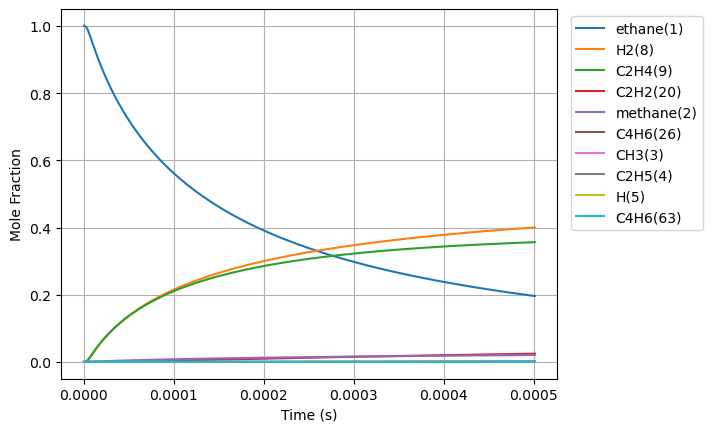

Cantera Simulation: Condition 1 Ethane Reaction Sensitivity


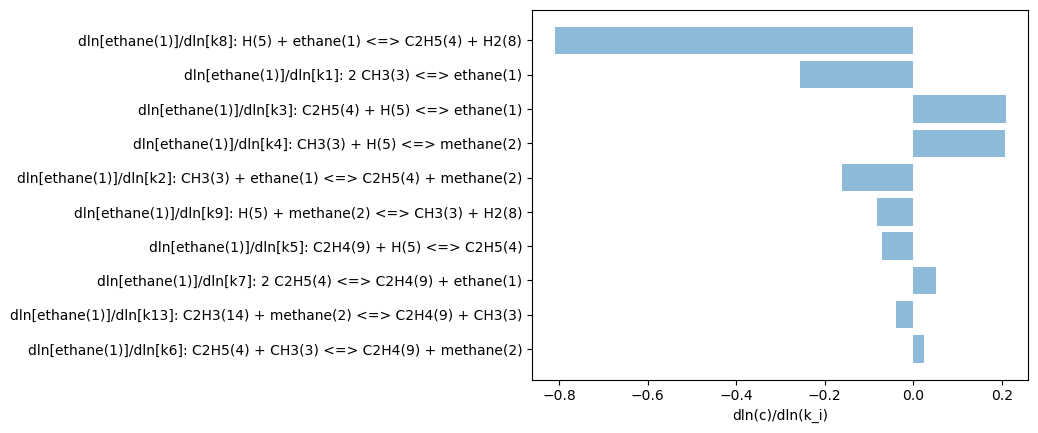

Cantera Simulation: Condition 1 Ethane Thermo Sensitivity


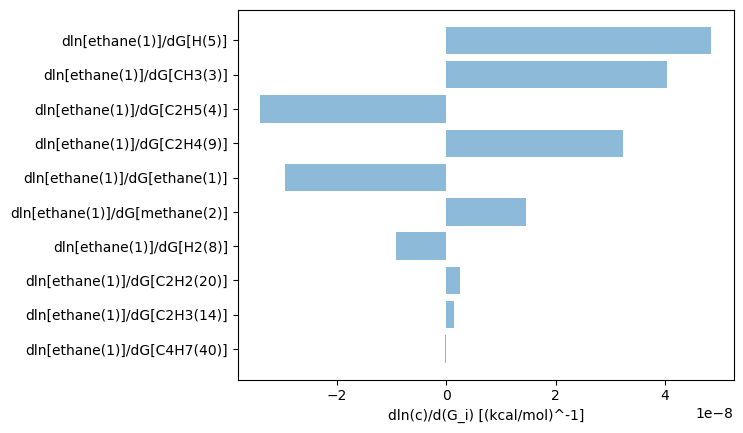

In [8]:
# Simulate and plot
alldata = job.simulate()
job.plot(alldata)

# Show the plots in the ipython notebook
for i, condition in enumerate(job.conditions):
    print('Cantera Simulation: Condition {0} Species Mole Fractions'.format(i+1))
    display(Image(filename="temp/{0}_mole_fractions.png".format(i+1)))
    
    print('Cantera Simulation: Condition {0} Ethane Reaction Sensitivity'.format(i+1))
    display(Image(filename="temp/{0}_ethane(1)_reaction_sensitivity.png".format(i+1)))
    
    if thermo_SA:
        print('Cantera Simulation: Condition {0} Ethane Thermo Sensitivity'.format(i+1))
        display(Image(filename="temp/{0}_ethane(1)_thermo_sensitivity.png".format(i+1)))

In [7]:
# Copy example input file to temp folder
shutil.copy('./data/ethane_model/input.py', './temp')

# We can run the same simulation using RMG's native solver
run_simulation(
    './temp/input.py',
    './data/ethane_model/chem_annotated.inp',
    './data/ethane_model/species_dictionary.txt',
)

Reading input file "/Users/kevin/Documents/Green_Lab/RMG/RMG-Py/ipython/temp/input.py"...
# Data sources
database(
    thermoLibraries = ['DFT_QCI_thermo', 'primaryThermoLibrary'],
    reactionLibraries = [],
    seedMechanisms = [],
    kineticsDepositories = ['training'],
    kineticsFamilies = 'default',
    kineticsEstimator = 'rate rules',
)

generatedSpeciesConstraints(
    allowed=['input species','seed mechanisms','reaction libraries'],
    maximumRadicalElectrons = 2,
    maximumCarbonAtoms = 10,
)

# List of species
species(
    label='ethane',
    reactive=True,
    structure=SMILES("CC"),
)

species(
    label='methane',
    reactive=True,
    structure=SMILES("C"),
)

# Reaction systems
simpleReactor(
    temperature=(1300,'K'),
    pressure=(1.0,'bar'),
    initialMoleFractions={
        "ethane": 1.0,
    },
    terminationTime=(0.5,'ms'),
    sensitivity=['ethane','methane']
)

simulator(
    atol=1e-16,
    rtol=1e-8,
)

model(
    toleranceMoveToCore=0.01,
    filterR

RMG Native Simulation: Species Mole Fractions


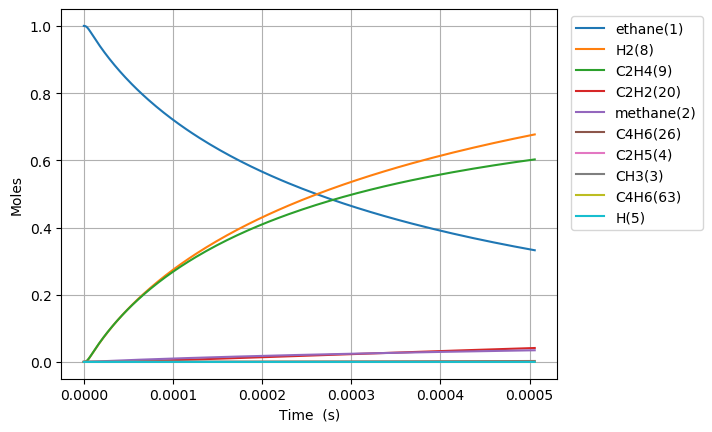

RMG Native Simulation: Ethane Reaction Sensitivity


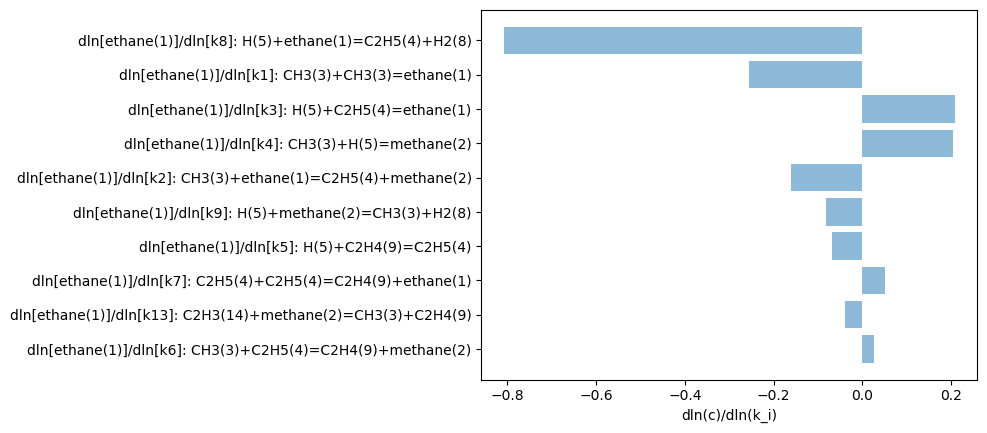

In [8]:
print('RMG Native Simulation: Species Mole Fractions')
display(Image(filename="./temp/solver/simulation_1_27.png"))

print('RMG Native Simulation: Ethane Reaction Sensitivity')
display(Image(filename="./temp/solver/sensitivity_1_SPC_1_reactions.png"))

CHEMKIN Simulation: Species Mole Fractions


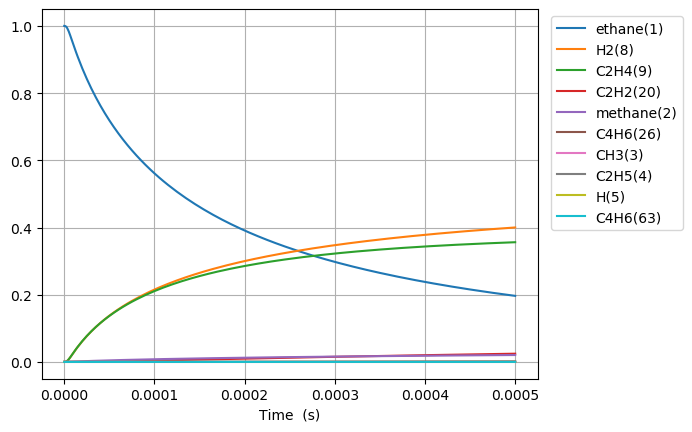

CHEMKIN Simulation: Ethane Reaction Sensitivity


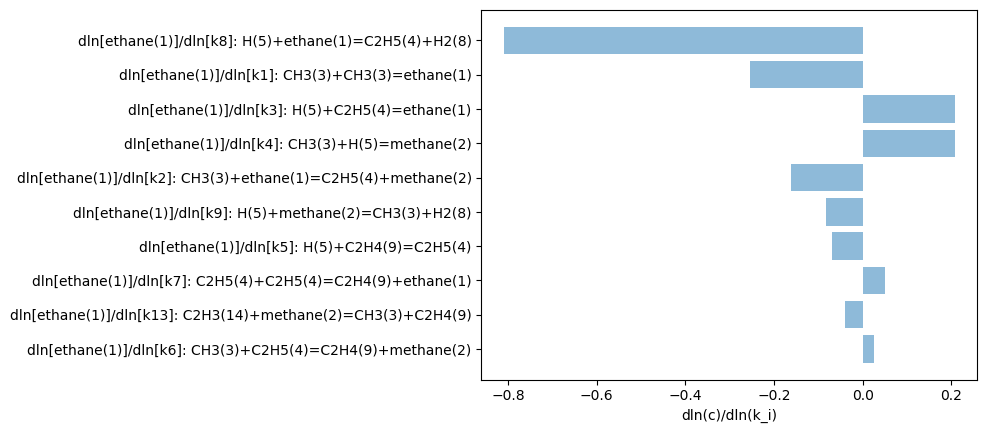

In [9]:
# Let's also compare against the same simulation and sensitivity analysis that was conducted in CHEMKIN
# and saved as a .csv file
time, data_list = parse_csv_data('./data/ethane_model/chemkin_mole_fractions.csv')
SimulationPlot(x_var=time, y_var=data_list, num_species=10).plot('./temp/chemkin_mole_fractions.png')
print('CHEMKIN Simulation: Species Mole Fractions')
display(Image(filename="./temp/chemkin_mole_fractions.png"))

time, data_list = parse_csv_data('./data/ethane_model/chemkin_sensitivity_ethane.csv')
ReactionSensitivityPlot(x_var=time, y_var=data_list, num_reactions=10).barplot('./temp/chemkin_sensitivity_ethane.png')
print('CHEMKIN Simulation: Ethane Reaction Sensitivity')
display(Image(filename="./temp/chemkin_sensitivity_ethane.png"))